In [1]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from scipy.stats import probplot
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import gaussian_kde

In [19]:
def PWL(x, params):
    slopes, intercepts = [params[1], params[2]], [params[3], params[4]]
    if x < intercepts[0]:
        return(slopes[0] * x + intercepts[1] - intercepts[0] * slopes[0])
    else:
        return(slopes[1] * x + intercepts[1] - intercepts[0] * slopes[1])

In [20]:
class Param:
    def __init__(self, name, sample_fun, pdf_fun, minmax, is_neg=False, step = 0.1):
        self.sample_fun = sample_fun
        self.pdf_fun = pdf_fun
        self.minmax = minmax
        self.prange = np.arange(self.minmax[0], self.minmax[1], step)
        self.name = name
        self.step = step
        self.is_neg = is_neg
    def sample(self):
        if self.is_neg:
            return -self.sample_fun()
        return self.sample_fun()
    def pdf(self, x):
        if self.is_neg:
            return self.pdf_fun(-x)
        return self.pdf_fun(x)

error_dist = lognorm(s=1, loc = 0.0, scale = 1)
slope_dist = lognorm(s=1, scale = 2)
cpx_dist   = norm(loc = 0, scale = 0.5)
cpy_dist   = lognorm(s=1, loc=1)
    
error     = Param("error", error_dist.rvs, error_dist.pdf, [0.01, 6])
neg_slope = Param("negative slope", slope_dist.rvs, slope_dist.pdf, [-12, -0.01], True)
pos_slope = Param("positive slope", slope_dist.rvs, slope_dist.pdf, [0.01, 12])
cpx       = Param("cpx", cpx_dist.rvs, cpx_dist.pdf, [-2, 2])
cpy       = Param("cpy", cpy_dist.rvs, cpy_dist.pdf, [1.01, 6])

params_list = [error, neg_slope, pos_slope, cpx, cpy]

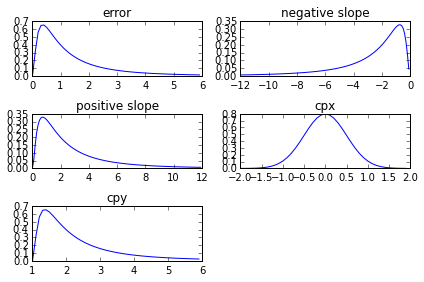

In [21]:
fig1 = plt.figure()
for i in range(len(params_list)):  
    ax = fig1.add_subplot(3,2,i+1)
    fig1.tight_layout()
    ax.plot(params_list[i].prange, params_list[i].pdf(params_list[i].prange))
    ax.set_title(params_list[i].name)
plt.show()

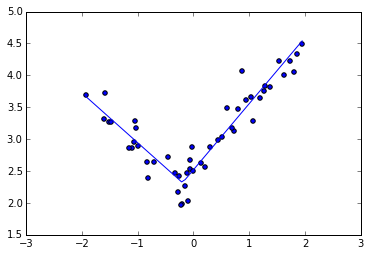

In [38]:
n_data = 50

rand_x = [uniform(loc=-2, scale=4).rvs() for i in range(n_data)]
rand_params = [param.sample() for param in params_list]
y = [PWL(x, rand_params) + norm(loc=0, scale=rand_params[0]).rvs() for x in rand_x]
plt.scatter(rand_x, y)
plt.plot(np.sort(rand_x), [PWL(x, rand_params) for x in np.sort(rand_x)])

In [39]:
def priors(params):
    return np.product([params_list[i].pdf(params[i]) for i in range(len(params_list))])
print priors(rand_params)

0.012484354294


In [40]:
def likelihood(x_list, y_list, params):
    return np.product([norm(loc=PWL(x, params), 
                            scale=params[0]).pdf(y) for x, y in zip(x_list, y_list)])
 
print likelihood(rand_x, y, rand_params)

997.225791687


In [41]:
def posterior(x, y, params):
    return priors(params) * likelihood(x, y, params)
print posterior(rand_x, y, rand_params)

12.4497200945


In [42]:
def posterior_cdf(x, y, params, index):
    post_cdf = [0]
    for value in params_list[index].prange:
        new_params = params[:]
        new_params[index] = value
        post_cdf.append(post_cdf[-1] + posterior(x, y, new_params))
    if post_cdf[-1] == 0:
        return [None]
    return post_cdf / post_cdf[-1]

def sample_step(x, y, params, index):
    post_cdf   = posterior_cdf(x, y, params, index)
    if post_cdf[0] is None:
        return params
    new_params = params[:]
    rand = uniform(0,1, size=1).rvs()
    for i in range(1, len(params_list[index].prange)):
        if rand < post_cdf[i]:
            dy, dx    = post_cdf[i] - post_cdf[i-1], params_list[index].prange[i] - params_list[index].prange[i-1]
            slope     = dy/dx
            intercept = post_cdf[i-1] - slope * params_list[index].prange[i-1]
            if slope == 0:
                new_params[index] = params_list[index].prange[i]
            else:
                new_params[index] = (rand - intercept) / slope
            break
    return new_params

def gibbs_sampled_list(x, y, n_samples, initial_params = None):
    sampled_params = [[param.sample() for param in params_list] or initial_params]
    i = 1
    while i < n_samples:
        params = sampled_params[-1][:]
        index  = randint(0, len(params_list)).rvs()
        candidate_params = sample_step(x, y, params, index)
        if not candidate_params[index] == params[index]:
            sampled_params.append(candidate_params)
            i += 1
    return sampled_params

In [ ]:
for i in range(4):
    t1 = time.clock()
    test_samples = gibbs_sampled_list(x=rand_x, y=y, n_samples=10**i)
    t2 = time.clock()
    print len(test_samples), t2-t1

In [43]:
sampled_list = gibbs_sampled_list(x=rand_x, y=y, n_samples=2000, initial_params = rand_params)

In [44]:
def get_one_dim_pdf(samples_list, index):
    return [sample[index] for sample in samples_list]

def get_estimated_params(samples_list):
    params = []
    #params = [np.median(params_list[index].prange) for index in range(len(samples_list[0]))]
    for index in range(len(samples_list[0])):
        densities = list(gaussian_kde(get_one_dim_pdf(samples_list, index))(params_list[index].prange))
        params.append(params_list[index].prange[densities.index(max(densities))])
        params
    return params

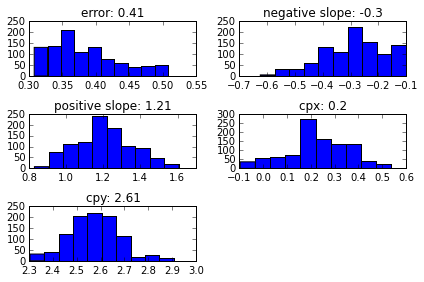

In [45]:
fig2 = plt.figure()
sub_list = sampled_list[1000:2000]
estimated_params = get_estimated_params(sub_list) 

for index in range(len(params_list)):  
    ax = fig2.add_subplot(3,2,index+1)
    fig2.tight_layout()
    ax.hist(get_one_dim_pdf(sub_list, index = index))
    ax.set_title(str(params_list[index].name) + ": " + str(estimated_params[index]))

plt.show()

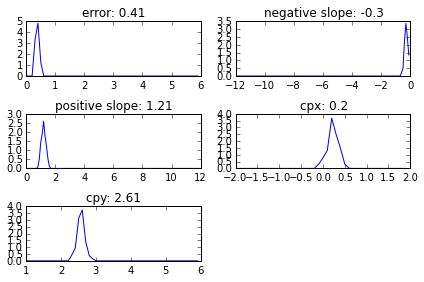

In [46]:
fig3 = plt.figure()
sub_list = sampled_list[1000:]
estimated_params = get_estimated_params(sub_list)    

for index in range(len(params_list)):  
    ax = fig3.add_subplot(3,2,index+1)
    fig3.tight_layout()
    density = gaussian_kde(get_one_dim_pdf(sub_list, index))
    densities = list(gaussian_kde(get_one_dim_pdf(sub_list, index))(params_list[index].prange))
    ax.plot(params_list[index].prange, densities)
    ax.set_title(str(params_list[index].name) + ": " + str(estimated_params[index]))

plt.show()

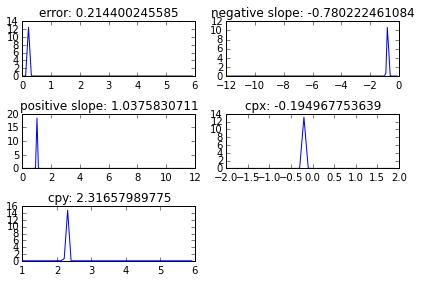

In [47]:
fig4 = plt.figure()
for index in range(len(params_list)):  
    new_params = rand_params[:]
    prange = params_list[index].prange
    yrange = []
    for p in prange:
        new_params[index] = p
        yrange.append(posterior(rand_x, y, new_params))
    ax = fig4.add_subplot(3,2,index+1)
    fig4.tight_layout()
    ax.plot(prange, yrange)
    ax.set_title(str(params_list[index].name) + ": " + str(rand_params[index]))

plt.show()

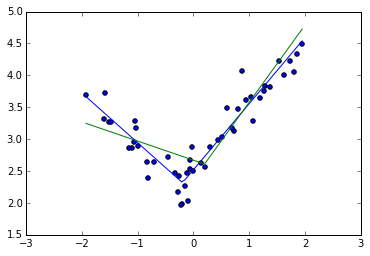

In [48]:
plt.scatter(rand_x, y)
plt.plot(np.sort(rand_x), [PWL(x, rand_params) for x in np.sort(rand_x)])
plt.plot(np.sort(rand_x), [PWL(x, estimated_params) for x in np.sort(rand_x)])

[ 7.536697]


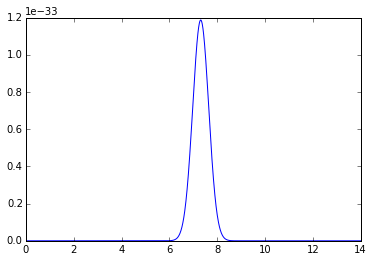

In [283]:
plt.plot(slope_range, [posterior(rand_x, y, 
                                 [rand_params[0], 
                                  rand_params[1], 
                                  slope, 
                                  rand_params[3], 
                                  rand_params[4] ]) for slope in slope_range])
print rand_params[2]

[ 0.81938985]


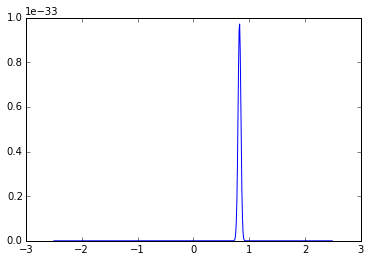

In [285]:
plt.plot(cpx_range, [posterior(rand_x, y, 
                                 [rand_params[0], 
                                  rand_params[1], 
                                  rand_params[2], 
                                  cpx, 
                                  rand_params[4] ]) for cpx in cpx_range])
print rand_params[3]

[ 1.13496473]


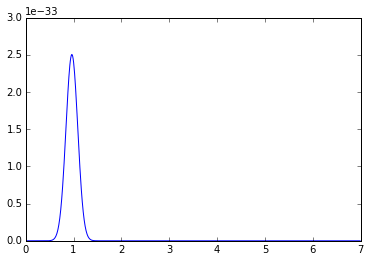

In [286]:
plt.plot(cpy_range, [posterior(rand_x, y, 
                                 [rand_params[0], 
                                  rand_params[1], 
                                  rand_params[2], 
                                  rand_params[3], 
                                  cpy ]) for cpy in cpy_range])
print rand_params[4]